In [1]:
import sys
sys.executable

'C:\\Users\\Monoid\\anaconda3\\envs\\nn\\python.exe'

In [2]:
from transformers import BertTokenizer
print("load bert tokenizer...")
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

load bert tokenizer...


In [3]:
import torch
print("cuda available :",torch.cuda.is_available())
print("available device count :",torch.cuda.device_count())
if torch.cuda.is_available():
    device_index = torch.cuda.current_device()
    print("device name:",torch.cuda.get_device_name(device_index))

cuda available : True
available device count : 1
device name: NVIDIA GeForce RTX 3070


In [4]:
from ndataset import readNsmcDataAll, make_collate_fn
dataTrain, dataTest = readNsmcDataAll()
collate_fn = make_collate_fn(tokenizer)

read train set
100%|██████████████████████████████████████████████████████████████████████| 150000/150000 [00:00<00:00, 208333.74it/s]
read test set
100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 260420.34it/s]


In [5]:
from transformers import BertModel
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT 로딩

In [26]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self,bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.1)
        self.lin1 = nn.Linear(768,256) #[batch_size,768] -> [batch_size,256]
        self.lin2 = nn.Linear(256,1)   #[batch_size,256] -> [batch_size,1]

    def forward(self,**kargs):
        emb = self.bert(**kargs)
        e1 = self.dropout(emb['pooler_output'])
        e2 = self.lin1(e1)
        w = self.lin2(e2)
        return w.squeeze() #[batch_size]

모델 선언. 비슷하게 감.

In [27]:
model = MyModel(bert)

학습 과정에서 벌어지는 일

In [8]:
model.cpu()

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [10]:
hidden = bert(**tokenizer(["사랑해요.","무서워요.","슬퍼요.","재미있어요."], return_tensors = 'pt', padding='longest'))['pooler_output']
hidden.size()

torch.Size([4, 768])

In [14]:
w = model.lin2(model.lin1(hidden)).squeeze()
w

tensor([0.1623, 0.1365, 0.1949, 0.1491], grad_fn=<SqueezeBackward0>)

In [15]:
torch.sigmoid(w)

tensor([0.5405, 0.5341, 0.5486, 0.5372], grad_fn=<SigmoidBackward0>)

In [16]:
labels = torch.tensor([1,0,0,1])

In [17]:
nn.BCEWithLogitsLoss()(w,labels.double())

tensor(0.6989, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [18]:
(w > 0).long() == labels

tensor([ True, False, False,  True])

이런 일이 벌어짐. sigmoid 는 나중에

In [28]:
device = torch.device('cuda')
model.to(device)
print(model)

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [20]:
bert.device

device(type='cuda', index=0)

모델을 모두 gpu로 보냄

In [22]:
from torch.utils.data import Dataset, DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(
        dataTrain,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
)
test_loader = DataLoader(
        dataTest,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
)

데이터 모델 준비

In [23]:
from torch.optim import AdamW
from groupby_index import groupby_index
from tqdm import tqdm

In [24]:
optimizer = AdamW(model.parameters(), lr=1.0e-5)
BCELoss = nn.BCEWithLogitsLoss()

학습 준비

In [30]:
TRAIN_EPOCH = 5

result = []
iteration = 0

t = []

model.zero_grad()

for epoch in range(TRAIN_EPOCH):
    model.train()
    print(f"epoch {epoch} start:")
    with tqdm(train_loader, unit="minibatch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        
        for batch in groupby_index(tepoch,8):
            corrects = 0
            totals = 0
            losses = 0
            
            optimizer.zero_grad()
            for mini_i,mini_l in batch:
                batch_inputs = {k: v.to(device) for k, v in list(mini_i.items())}
                batch_labels = mini_l.to(device)
                
                output = model(**batch_inputs)
                loss = BCELoss(output, batch_labels.double())
            
                prediction = (output > 0).to(device,dtype=torch.int64)
                corrects += (prediction == batch_labels).sum().item()
                totals += prediction.size()[0]
                losses += loss.item()
                loss.backward()

            optimizer.step()
            accuracy = corrects / totals
            result.append({"iter":iteration,"loss":losses,"accuracy":accuracy})
            tepoch.set_postfix(loss=losses, accuracy= accuracy)
            iteration += 1

epoch 0 start:


Epoch 0: 100%|███████████████████████████████████| 9375/9375 [12:35<00:00, 12.41minibatch/s, accuracy=0.875, loss=2.58]


epoch 1 start:


Epoch 1: 100%|███████████████████████████████████| 9375/9375 [12:35<00:00, 12.41minibatch/s, accuracy=0.898, loss=2.18]


epoch 2 start:


Epoch 2:   1%|▎                                    | 82/9375 [00:06<12:30, 12.39minibatch/s, accuracy=0.867, loss=2.08]


KeyboardInterrupt: 

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

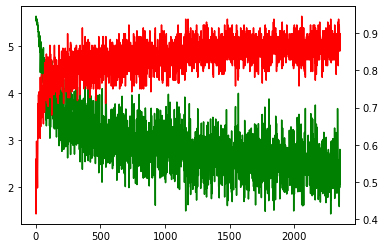

In [32]:
iters = [item["iter"] for item in result]
fig, ax1 = plt.subplots()
ax1.plot(iters,[item["loss"] for item in result],'g')
ax2 = ax1.twinx()
ax2.plot(iters,[item["accuracy"] for item in result],'r')
plt.xlabel("iter")
plt.show()

In [91]:
torch.cuda.empty_cache()
print(f"gpu allocated : {torch.cuda.memory_allocated() // 1024**2} MB")
print(f"gpu reserved : {torch.cuda.memory_reserved() // 1024 ** 2} MB")

gpu allocated : 1776 MB
gpu reserved : 1910 MB


In [38]:
torch.save(model.state_dict(), "model.zip")

In [39]:
del batch_inputs
del batch_labels
del loss
del optimizer

In [42]:
model.eval()
collect_list = []
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_i,batch_l in tepoch:
            batch_inputs = {k: v.cuda(device) for k, v in list(batch_i.items())}
            batch_labels = batch_l.cuda(device)
            output = model(**batch_inputs)
            loss = BCELoss(output, batch_labels.double())
            
            prediction = (output > 0).to(device,dtype=torch.int64)
            correct =  (prediction == batch_labels).sum().item()
            accuracy = correct / prediction.size()[0]
            
            collect_list.append({"loss":loss.item(),"accuracy":accuracy, "batch_size":batch_labels.size(0),
                                "predict":prediction.cpu(),
                                "actual":batch_labels.cpu()})

100%|███████████████████████████████████████████████████████████████████████████| 3125/3125 [01:26<00:00, 36.25batch/s]


In [43]:
def getConfusionMatrix(predict,actual,attention_mask):
    ret = torch.zeros((2,2),dtype=torch.long)
    for p_s,a_s in zip(predict,actual):
        ret[p_s,a_s] += 1
    return ret

In [44]:
total_loss = 0
total_accuracy = 0
total_size = 0
confusion = torch.zeros((2,2),dtype=torch.long)

for item in collect_list:
    batch_size = item["batch_size"]
    total_loss += batch_size * item["loss"]
    total_accuracy += batch_size * item["accuracy"]
    total_size += batch_size
    confusion += getConfusionMatrix(item["predict"],item["actual"],item["attention_mask"])
print(f"""average_loss : {total_loss/total_size}, average_accuracy : {total_accuracy/total_size}, size :{total_size}""")

average_loss : 0.3252932393981423, average_accuracy : 0.86136, size :50000


In [45]:
confusion

tensor([[21382,  3487],
        [ 3445, 21686]])

In [46]:
def getF1Score(confusion,c):
    TP = confusion[c,c]
    FP = confusion[c].sum() - TP
    FN = confusion[:,c].sum() - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1Score = (2*precision*recall)/(precision + recall)
    return f1Score

In [49]:
print(f"f1 score : {getF1Score(confusion,1)}")

f1 score : 0.862197756767273


In [50]:
model.eval()

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

한번 테스트해보기

In [90]:
sen = input()
inputs = tokenizer(sen, return_tensors = 'pt', padding='longest')
output = model(**{k: v.to(device) for k,v in inputs.items() })
prob = torch.sigmoid(output).item()
print("긍정적 output :",prob * 100,"%")
print("부정적 output :", (1-prob) * 100,"%")

KeyboardInterrupt: Interrupted by user

```
5471412	맘에 들어요~ 0
```
라벨이 잘못 붙어있는 것들이 있다. 별점가지고만 긍정, 부정을 매긴 것 같다.